In [1]:
import os
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import random

%matplotlib inline

n_mult=1
noise_level=.05

directory= './Data/Local Sensitivity/'
# directory = './Data/Global Sensitivity'
runs = []
for filename in os.listdir(directory):
    if filename.startswith('gen'):
        run = int(filename.split('_')[2].split('.')[0])
        runs.append(run)
       
count=0

# set up the Pandas Dataframes
volts=pd.DataFrame(columns=range(255),dtype=np.float64)
times=pd.DataFrame(columns=range(255),dtype=np.float64)
vals=pd.DataFrame(columns=range(41),dtype=np.float64)
temp1=[]
temp2=[]
temp3=[]
names=[]
count=0
# Iterate through the files
for run in sorted(runs):
    count=count+1
    if True:
        filename = '/gen_data_' + str(run) + '.csv'
        data = pd.read_csv(directory + filename, sep=',')
        temp1=[]
        temp2=[]
        temp3=[]
        # parse the data
        for column in data.columns:
            if column.find('olts')>0:
                temp1=np.concatenate((temp1,data[column].tolist()))
            if column.find('ime')>0:
                temp3=np.concatenate((temp3,data[column].tolist()))
            if column.find('olts') + column.find('urrent') + column.find('ime') < -2:
                if data[column][0]!=0:
                    temp2.append(data[column][0])
        volts.loc[run,:]=temp1
        vals.loc[run,:]=temp2
        times.loc[run,:]=temp3


for column in data.columns:
    if column.find('olts') + column.find('urrent') + column.find('ime') < -2:
        if data[column][0]!=0:
            names.append(column) 

# Split the data into 'test' and 'training' sets
train = sorted(random.sample(range(volts.shape[0]), int(volts.shape[0]*(3.0/4))))
test = [x for x in range(volts.shape[0]) if x not in train]
P=vals
P_mean = P.mean()
P_std = P.std()

# Normalize the data
P = (P - P.mean())/P.std()

times_train=times.iloc[train,:]
Z_train = volts.iloc[train,:]
P_train = P.iloc[train,:]

times_test = times.iloc[test,:]
Z_test = volts.iloc[test,:]
P_test = P.iloc[test,:]

X_train = pd.DataFrame()
Y_train = pd.DataFrame()

X_train_noise = pd.DataFrame()
X_test_noise = pd.DataFrame()

X_test = pd.DataFrame()
Y_test = pd.DataFrame()

# Add noise and possibly duplicate
for _ in range(n_mult):
                      
    X_test_noise = pd.concat((X_test, Z_test + np.random.randn(Z_test.shape[0],Z_test.shape[1])*noise_level))
    X_train_noise = pd.concat((X_train, Z_train + np.random.randn(Z_train.shape[0],Z_train.shape[1])*noise_level))
    
    Y_train = pd.concat((Y_train, P_train))
    X_train = pd.concat((X_train, Z_train))
    
    X_test = pd.concat((X_test, Z_test))  
    Y_test = pd.concat((Y_test, P_test))

times_train=np.array(times_train)    
X_train_noise = np.array(X_train_noise)
X_train = np.array(X_train)
Y_train = np.array(Y_train)


times_test=np.array(times_test)
X_test_noise = np.array(X_test_noise)
X_test = np.array(X_test)
Y_test = np.array(Y_test)


YY_train = Y_train
XX_train = X_train
print 'done'

X_full = np.array(volts)
Y_full = np.array(vals)
print count

done
406


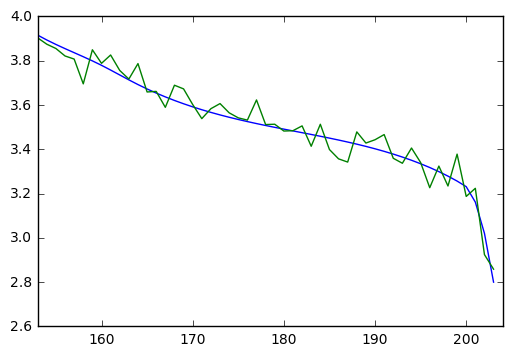

In [2]:
y_1=[]
for i in range(153,204):
    y_1.append(i)
for i in range(1):
    plt.plot(y_1,X_train[i][153:204])
    plt.plot(y_1,X_train_noise[i][153:204])

plt.xlim(153,204)
plt.show()

In [3]:
# Running different Regression methods
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn import linear_model

import time
print("extra trees")
start_time = time.time()
etr = ExtraTreesRegressor(n_estimators=200, n_jobs=-1,max_depth=22)
etr.fit(X_train,Y_train)
print("--- %s seconds ---" % (time.time() - start_time))
print('Test:', etr.score(X_test,Y_test), 'Train:', etr.score(X_train,Y_train))
start_time = time.time()

print("KNN")
start_time = time.time()
knn = KNeighborsRegressor(n_neighbors=40,weights = 'distance')
knn.fit(X_train,Y_train)
print("--- %s seconds ---" % (time.time() - start_time))
print('Test:', knn.score(X_test,Y_test), 'Train:', knn.score(X_train,Y_train))

print("linear")
start_time = time.time()
lin = linear_model.LinearRegression()
lin.fit(X_train,Y_train)
print("--- %s seconds ---" % (time.time() - start_time))
print('Test:', lin.score(X_test,Y_test), 'Train:', lin.score(X_train,Y_train))


extra trees
--- 1.02600002289 seconds ---
('Test:', -0.088507916560157177, 'Train:', 0.39736399023633628)
KNN
--- 0.00200009346008 seconds ---
('Test:', -0.072017564415671767, 'Train:', 0.3847383117343503)
linear
--- 0.0090000629425 seconds ---
('Test:', -1.1278388630938753e+20, 'Train:', 0.39071196144322179)


56


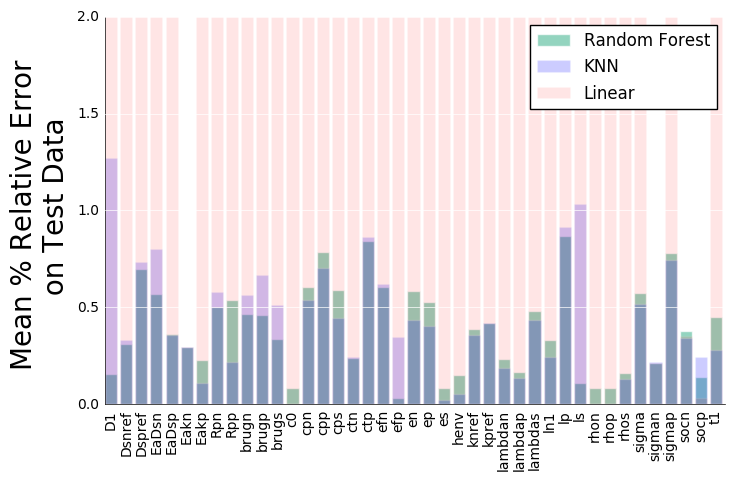

In [4]:
### plot all 3 on the same chart
import prettyplotlib as ppl
print len(data.columns)
a = []
aa = []
aaa = []

predicted1 = etr.predict(X_test)
predicted2 = knn.predict(X_test)
predicted3 = lin.predict(X_test)
for j in range(Y_test.shape[1]):
    re = []
    for i in range(len(Y_test)):
        predicted = predicted1[i][j]*P_std[j] + P_mean[j]
        true = Y_test[i][j]*P_std[j] + P_mean[j]
        re.append(np.abs((predicted - true)/true))
    a.append(re)
    re=[]
    for i in range(len(Y_test)):
        predicted = predicted2[i][j]*P_std[j] + P_mean[j]
        true = Y_test[i][j]*P_std[j] + P_mean[j]
        re.append(np.abs((predicted - true)/true))
    aa.append(re)
    re=[]
    for i in range(len(Y_test)):
        predicted = predicted3[i][j]*P_std[j] + P_mean[j]
        true = Y_test[i][j]*P_std[j] + P_mean[j]
        re.append(np.abs((predicted - true)/true))
    aaa.append(re)
    
results1 = np.array(a)
means1 = np.ndarray(shape=(P.shape[1],))
stds1 = np.ndarray(shape=(P.shape[1],))
results2 = np.array(aa)
means2 = np.ndarray(shape=(P.shape[1],))
stds2 = np.ndarray(shape=(P.shape[1],))
results3 = np.array(aaa)
means3 = np.ndarray(shape=(P.shape[1],))
stds3 = np.ndarray(shape=(P.shape[1],))


for p in range(results1.shape[0]):
    mean1 = results1[p].mean()
    std1 = results1[p].std()
    mean2 = results2[p].mean()
    std2 = results2[p].std()
    mean3 = results3[p].mean()
    std3 = results3[p].std()
    
    means1[p] = mean1
    stds1[p] = std1/np.sqrt(results1.shape[1])
    means2[p] = mean2
    stds2[p] = std2/np.sqrt(results2.shape[1])
    means3[p] = mean3
    stds3[p] = std3/np.sqrt(results3.shape[1])
fig = plt.figure(1, figsize=(8,5))
ppl.bar(range(results1.shape[0]), means1*100,
        xticklabels=names, grid='y', alpha=0.7,label='Random Forest') # etr
ppl.bar(range(results2.shape[0]), means2*100, 
        grid='y', color='b', alpha=0.2,label='KNN') # knn
ppl.bar(range(results3.shape[0]), means3*100,
        grid='y', color='r', alpha=0.1, label='Linear') # lin
plt.ylim(0,2)
plt.legend()
plt.ylabel('Mean % Relative Error \n on Test Data', fontsize=20)
plt.xticks(rotation='vertical', ha='center')
plt.xlim(0,41)
plt.show()

In [8]:
from bokeh.io import output_file, show
from bokeh.layouts import widgetbox
from bokeh.models.widgets import Slider

output_file("slider.html")

slider = Slider(start=0, end=4096, value=1, step=1, title="Stuff")

show(widgetbox(slider))

INFO:bokeh.core.state:Session output file 'slider.html' already exists, will be overwritten.


In [12]:
print predicted1

[[ -9.64224345e-03  -2.68917697e-02  -2.68917697e-02 ...,   9.08721969e-02
   -2.68917697e-02   8.28374616e-02]
 [ -9.64224345e-03  -2.68917697e-02  -2.68917697e-02 ...,   9.08721969e-02
   -2.68917697e-02   8.28374616e-02]
 [ -1.21685294e-13  -3.54433525e-01   8.46552911e-01 ...,  -5.67042509e-02
   -2.68917697e-02  -2.68917697e-02]
 ..., 
 [ -1.21685294e-13  -1.57908472e-01   2.32049081e+00 ...,  -4.25645370e-01
   -2.68917697e-02  -2.68917697e-02]
 [ -1.21685294e-13  -3.93555672e+00   1.68724342e+00 ...,   1.70839730e-02
   -2.68917697e-02  -2.68917697e-02]
 [ -1.21685294e-13  -6.42487406e+00   3.00649986e-01 ...,   1.70839730e-02
   -2.68917697e-02  -2.68917697e-02]]


In [18]:
from bokeh.layouts import column
from bokeh.models import CustomJS, ColumnDataSource, Slider
from bokeh.plotting import Figure, output_notebook, show

output_notebook("callback.html")

x = [x*0.005 for x in range(0, 200)]
y = x

source = ColumnDataSource(data=dict(x=x, y=y))

plot = Figure(plot_width=400, plot_height=400)
plot.line('x', 'y', source=source, line_width=3, line_alpha=0.6)

callback = CustomJS(args=dict(source=source), code="""
        var data = source.data;
        var f = cb_obj.value
        x = data['x']
        y = data['y']
        for (i = 0; i < x.length; i++) {
            y[i] = Math.pow(x[i], f)
        }
        source.trigger('change');
    """)

slider = Slider(start=0.1, end=4, value=1, step=.1, title="power", callback=callback)

layout = column(slider, plot)

show(layout)

AttributeError: 'str' object has no attribute 'mode'